In [ ]:
!pip install pyogrio==0.7.2 geopandas==0.14.3 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.0/22.0 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.1 MB/s eta 0:00:00


In [ ]:
%load_ext autoreload
%autoreload 2

import sys, os
from IPython.core.magic import register_cell_magic
from glob import glob
import numpy as np
from google.colab import drive
import ee
import geemap.foliumap as geemap
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import pyproj
import pyarrow

gpd.options.io_engine = "pyogrio"
os.environ["PYOGRIO_USE_ARROW"] = "1"

In [ ]:
ee.Authenticate()
ee.Initialize(project="215656163750")
drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/Colab Notebooks/')
import utils, explore

@register_cell_magic
def skip(line, cell):
    return

Mounted at /content/drive


## Basic farm information

In [ ]:
path = "/content/drive/MyDrive/CAFO_data/South_Africa/"
df = pd.read_csv(f"{path}SouthAfrica_N2P.csv")

df['Latitude'] = df["Latitude, longitude"].str.split(",").str[0].astype(float)
df['Longitude'] = df["Latitude, longitude"].str.split(",").str[1].astype(float)

farms = gpd.GeoDataFrame(df, geometry=\
                       gpd.points_from_xy(df["Longitude"], df["Latitude"],\
                                          crs="EPSG:4326"))

farms = farms[["geometry", "Region", "Number", "Info"]]\
         .rename(columns={"Number": "Number of animals"})

print(f"The smallest farm has {farms['Number of animals'].min()} pigs")
print(f"The largest farm has {farms['Number of animals'].max()} pigs")

The smallest farm has 3600 pigs
The largest farm has 60000 pigs


In [ ]:
# Get ADM1-level boundaries. For some reason there are only polygons in these
# shapefiles, and no province names (!)

boundaries = gpd.read_file(f"{path}shapefiles/zaf_admbnda_adm1_sadb_ocha_20201109.shp").\
             set_crs("EPSG:4326")

In [ ]:
min_building_size = 200

In [ ]:
%%skip

# Skip this cell unless there's some reason to recreate the building file, e.g
# if min_building_size has changed. Read the existing file in the next cell
# instead

# We will only get buildings in the Eastern and Western Cape regions, which is
# where most of the farms are located. It seems a bit much to get buildings
# for a whole province to locate just one or two farms. So, the remainder of the
# analysis will be just for the farms in Eastern Cape and Western Cape.

for index, name in zip([0, 8], ["EasternCape", "WesternCape"]):
  province = gpd.GeoDataFrame(boundaries.iloc[index].to_frame().T).set_crs("EPSG:4326")
  geom = geemap.geopandas_to_ee(province)
  buildings_fc = (
      ee.FeatureCollection(f"projects/sat-io/open-datasets/VIDA_COMBINED/ZAF")
      .filter(ee.Filter.gt('area_in_meters', min_building_size))
      .filterBounds(geom)
  )

  utils.write_to_file(buildings_fc, f"{name}_buildings_{min_building_size}_sq_m",\
                      'South_Africa')

utils.ee_task_status()

In [ ]:
%%time
# Read the data into a geodataframe (takes about 1.5 mins, 570,000 buildings)

gdf1 = gpd.read_file(f"{path}WesternCape_buildings_{min_building_size}_sq_m.geojson")
gdf2 = gpd.read_file(f"{path}EasternCape_buildings_{min_building_size}_sq_m.geojson")

buildings = pd.concat([gdf1, gdf2], ignore_index=True)
buildings.rename(columns={"area_in_meters": "Area (sq m)"}, inplace=True)
print(f"There are {len(buildings)} buildings > {min_building_size} sq m")

There are 570267 buildings > 200 sq m
CPU times: user 1min 3s, sys: 1.72 s, total: 1min 5s
Wall time: 1min 8s


In [ ]:
# Find all the buildings that are within <farm_dist> m of a farm, and those
# that are more than <not_farm_dist> away

crs = "EPSG:2055"
farm_dist = 150
not_farm_dist = 1000
farm_buildings, other_buildings = explore.join_farms_and_buildings(farms,\
                                                                  buildings,\
                                                                  farm_dist,\
                                                                  not_farm_dist,\
                                                                  crs)

print(f"There are {len(farm_buildings)} buildings within {farm_dist} m of farm coords ")
print(f"There are {len(other_buildings)} buildings >{not_farm_dist} m from\
 farm coords (any farm type) ")

There are 284 buildings within 150 m of farm coords 
There are 569353 buildings >1000 m from farm coords (any farm type) 


In [ ]:
# Drop all but the largest building per farm, calculate the lengths and aspect
# ratios of the remaining buildings

max_farm_bldgs = farm_buildings.sort_values('Area (sq m)', ascending=False)\
                              .drop_duplicates(['Parent coords'])
print(f"{len(farm_buildings)} buildings --> {len(max_farm_bldgs)} buildings")
temp = farms[farms['Region'].isin(["Eastern Cape", "Western Cape"])]
print(f"Started with {len(temp)} farms in Eastern Cape + Western Cape")

max_farm_bldgs = explore.get_dimensions(max_farm_bldgs, crs=crs)

284 buildings --> 21 buildings
Started with 21 farms in Eastern Cape + Western Cape


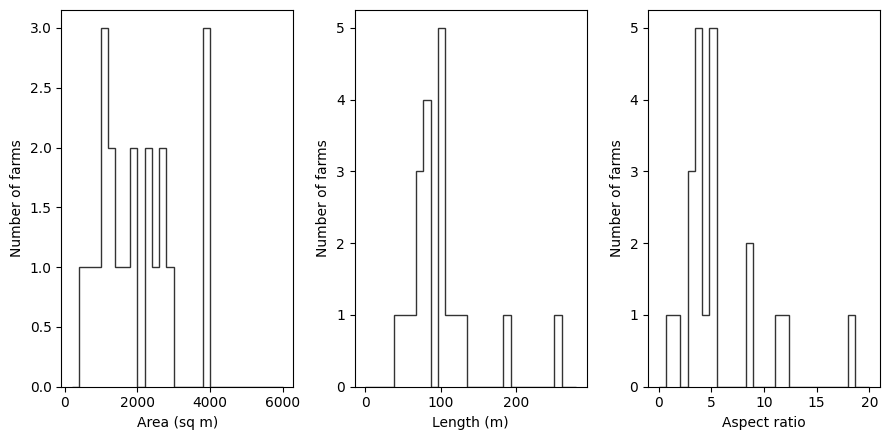

In [ ]:
bins = explore.define_bins()

_, axes = plt.subplots(1, 3, figsize=(9, 4.5))
for col, ax in zip(["Area (sq m)", "Length (m)", "Aspect ratio"], axes):
  ax.hist(max_farm_bldgs[col], bins[col], histtype='step', color='0.2')
  ax.set_xlabel(col)
  ax.set_ylabel("Number of farms")

plt.tight_layout()

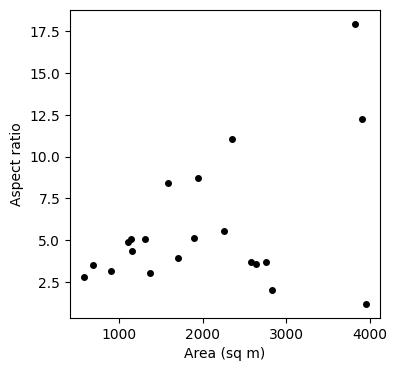

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(max_farm_bldgs['Area (sq m)'], max_farm_bldgs["Aspect ratio"], "ko", ms=4)
ax.set_xlabel("Area (sq m)")
ax.set_ylabel("Aspect ratio")
plt.show()

## Visual examination of farm candidates

Most of these farms have standard-ish buildings in recognisably CAFO-like arrangements. The three buildings < 1000 sq m are on CAFOs that genuinely have smaller-than average buildings. The large and square-ish ones are the usual BFD errors, plus one case where the largest building within 150 m of the farm coordinates is actually on a neighbouring dairy farm.

In [ ]:
# Step through the farms on a map

_ = explore.loop_over_buildings(max_farm_bldgs)

Working on feature 1 of 21


,geometry,Parent coords,Area (sq m),Number of animals,Length (m),Aspect ratio
0,"POLYGON ((18.75904 -33.11478, 18.75870 -33.114...",POLYGON ((18.758050364472275 -33.1160162045603...,3957.1769,6600,80.888798,1.18829


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 2 of 21


,geometry,Parent coords,Area (sq m),Number of animals,Length (m),Aspect ratio
1,"POLYGON ((26.83000 -31.92873, 26.83020 -31.927...",POLYGON ((26.827991063414803 -31.9269040947632...,3910.281738,6700,254.50497,12.249074


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 3 of 21


,geometry,Parent coords,Area (sq m),Number of animals,Length (m),Aspect ratio
2,"POLYGON ((21.28514 -34.13253, 21.28513 -34.132...",POLYGON ((21.28166079118717 -34.13406888688819...,3829.1563,13500,281.152866,17.947719


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 4 of 21


,geometry,Parent coords,Area (sq m),Number of animals,Length (m),Aspect ratio
3,"POLYGON ((18.97002 -33.85340, 18.96970 -33.853...",POLYGON ((18.969018668654225 -33.8519103534826...,2829.8041,4500,81.57775,2.023731


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 5 of 21


,geometry,Parent coords,Area (sq m),Number of animals,Length (m),Aspect ratio
4,"POLYGON ((19.75863 -33.41249, 19.75834 -33.412...",POLYGON ((19.754743827223113 -33.4118274087367...,2766.216309,6900,104.404793,3.69171


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 6 of 21


,geometry,Parent coords,Area (sq m),Number of animals,Length (m),Aspect ratio
5,"POLYGON ((27.53511 -31.42749, 27.53411 -31.427...","POLYGON ((27.533579507761 -31.427357810345626,...",2638.797852,60000,97.790075,3.560153


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 7 of 21


,geometry,Parent coords,Area (sq m),Number of animals,Length (m),Aspect ratio
6,"POLYGON ((18.54922 -33.38384, 18.54917 -33.383...",POLYGON ((18.546593742544857 -33.3836366960421...,2578.972168,60000,100.831775,3.713251


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 8 of 21


,geometry,Parent coords,Area (sq m),Number of animals,Length (m),Aspect ratio
7,"POLYGON ((18.79415 -33.77692, 18.79418 -33.776...",POLYGON ((18.79314923303542 -33.77823246264808...,2358.6977,16000,183.501954,11.043


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 9 of 21


,geometry,Parent coords,Area (sq m),Number of animals,Length (m),Aspect ratio
8,"POLYGON ((26.84252 -31.90651, 26.84202 -31.905...",POLYGON ((26.84058438209528 -31.90602129574387...,2252.799316,5100,113.801051,5.516836


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 10 of 21


,geometry,Parent coords,Area (sq m),Number of animals,Length (m),Aspect ratio
9,"POLYGON ((18.86254 -33.15442, 18.86254 -33.154...",POLYGON ((18.859833983610752 -33.1543972933846...,1947.1521,6300,135.104686,8.688532


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 11 of 21


,geometry,Parent coords,Area (sq m),Number of animals,Length (m),Aspect ratio
10,"POLYGON ((26.87125 -32.79658, 26.87125 -32.796...",POLYGON ((26.869319376755485 -32.7960920663584...,1894.060913,15000,99.131907,5.138662


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 12 of 21


,geometry,Parent coords,Area (sq m),Number of animals,Length (m),Aspect ratio
11,"POLYGON ((18.53388 -33.30907, 18.53379 -33.309...","POLYGON ((18.53308850889136 -33.309255445473, ...",1709.519897,60000,101.409781,3.915648


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 13 of 21


,geometry,Parent coords,Area (sq m),Number of animals,Length (m),Aspect ratio
12,"POLYGON ((18.87953 -33.79910, 18.87830 -33.798...",POLYGON ((18.87696825520916 -33.79942761922167...,1588.772827,8000,118.578126,8.433561


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 14 of 21


,geometry,Parent coords,Area (sq m),Number of animals,Length (m),Aspect ratio
13,"POLYGON ((18.79317 -33.64260, 18.79249 -33.642...",POLYGON ((18.791660695376812 -33.6434190892657...,1365.271606,16000,66.543053,3.052647


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 15 of 21


,geometry,Parent coords,Area (sq m),Number of animals,Length (m),Aspect ratio
14,"POLYGON ((26.82900 -31.95325, 26.82818 -31.953...",POLYGON ((26.8277336380063 -31.951858038124936...,1311.913818,10000,82.297423,5.044019


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 16 of 21


,geometry,Parent coords,Area (sq m),Number of animals,Length (m),Aspect ratio
15,"POLYGON ((25.81314 -32.80045, 25.81311 -32.800...",POLYGON ((25.810934666160964 -32.8012040556411...,1158.088745,8000,74.892861,4.350309


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 17 of 21


,geometry,Parent coords,Area (sq m),Number of animals,Length (m),Aspect ratio
16,"POLYGON ((20.12861 -33.93123, 20.12857 -33.931...",POLYGON ((20.125865176418678 -33.9305582528579...,1141.625488,15000,78.021203,5.052105


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 18 of 21


,geometry,Parent coords,Area (sq m),Number of animals,Length (m),Aspect ratio
17,"POLYGON ((18.64402 -33.49405, 18.64386 -33.494...",POLYGON ((18.642607408238067 -33.4935401464868...,1109.809204,7000,75.778258,4.911717


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 19 of 21


,geometry,Parent coords,Area (sq m),Number of animals,Length (m),Aspect ratio
18,"POLYGON ((26.67873 -30.71304, 26.67842 -30.712...",POLYGON ((26.6772076349203 -30.711887907090038...,908.335876,4500,68.959464,3.145069


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 20 of 21


,geometry,Parent coords,Area (sq m),Number of animals,Length (m),Aspect ratio
19,"POLYGON ((25.98781 -33.65959, 25.98775 -33.659...",POLYGON ((25.986537768897943 -33.6585093873497...,690.416626,3600,49.891541,3.514531


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 21 of 21


,geometry,Parent coords,Area (sq m),Number of animals,Length (m),Aspect ratio
20,"POLYGON ((25.80927 -32.78439, 25.80927 -32.784...",POLYGON ((25.807277922396427 -32.7831170068340...,581.837097,12000,40.556098,2.792133


Enter reject to reject, exit to exit, or any key to continue  n
